# Cos2g and Pol % Contribution Test

In [348]:
# === IMPORT ===
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jn_zeros, j0, j1, erfc

## Generate Input Field
- Hourglass magnetic field geometry 
- Turbulence
- Option to change LOS integratation axis

In [451]:
# === FIELD USER-INPUTS ===
nskip = 1
n = 8
n_theta = 8
R_outer = 5.0
h = 1.0
B0 = 1.0
Bm = 1.0
betam = Bm / B0
N_terms = 3    # reduced to avoid overflow

# geometry
iaxis = 0 # observing axis, 2 = LOS

# Stokes
I0 = 1.0               # intensity per voxel (constant here)

# Turbulence along LOS: controls angular perturbations (radians)
turb_sigma = 0.01      # larger -> stronger angular perturbations -> more depolarization
corr_r = 1        # AR(1) correlation coefficient along the z-axis (0 = white; close to 1 = highly correlated)

# DCF parameters (arbitrary units). For physical units, set rho and sigma_v appropriately.
rho = 1.0              # mass density (set to 1 for toy model)
sigma_v = 1.0          # LOS velocity dispersion (required by DCF formula)
cf_prefactor = np.sqrt(4 * np.pi * rho) * sigma_v

In [452]:
# === INITIALIZE BOX ===
# Grids (dimensionless: r, z ∈ [-2, 2])
r = np.linspace(-0.25, 0.25, n)
z = np.linspace(-0.25, 0.25, n)
R_grid, Z_grid = np.meshgrid(r, z, indexing='xy')

# Precompute Bessel roots and weights
roots = jn_zeros(1, N_terms)          # λ_n (zeros of J1)
weights = 2 / (roots * j0(roots)**2)  # weighting for summation
eta = h / R_outer

# Initialize field arrays
Br_array = np.zeros_like(R_grid)
Bz_array = np.zeros_like(R_grid)

In [453]:
# === COMPUTE Br and Bz ===
for i in range(n):
    for j in range(n):
        ir = r[i]
        iz = z[j]

        J0_eval = j0(roots * ir)
        J1_eval = j1(roots * ir)

        arg_erfc_neg = roots * eta / 2 - iz / eta
        arg_erfc_pos = roots * eta / 2 + iz / eta

        ernie_neg = erfc(arg_erfc_neg)
        ernie_pos = erfc(arg_erfc_pos)

        exp_neg = np.exp(-roots * iz)
        exp_pos = np.exp(roots * iz)

        brackets0 = ernie_pos * exp_pos + ernie_neg * exp_neg
        brackets1 = ernie_neg * exp_neg - ernie_pos * exp_pos

        Br = np.sum(weights * J1_eval * betam * brackets1)
        Bz = np.sum(weights * J0_eval * betam * brackets0) + 1

        Br_array[i, j] = Br / B0
        Bz_array[i, j] = Bz / B0

In [454]:
# === CONVERSION TO CARTESIAN COORDS ===
theta = np.linspace(0, 2 * np.pi, n_theta)
R2D, T2D, Z = np.meshgrid(r, theta, z, indexing='xy')

X = R2D * np.cos(T2D)
Y = R2D * np.sin(T2D)

# create magnetic field components
Br3D = np.tile(Br_array[np.newaxis, :, :], (n_theta, 1, 1))
Bz3D = np.tile(Bz_array[np.newaxis, :, :], (n_theta, 1, 1))

bx_cart = Br3D * np.cos(T2D)
by_cart = Br3D * np.sin(T2D)
bz_cart = Bz3D


In [455]:
# === TURBULENCE ===
delta_theta = np.zeros((n, n, n))

for ix in range(n):
    for iy in range(n):
        val = np.random.normal(scale=turb_sigma) # generate an initial random turbulent angle, based on turb_sigma - the maximum angular deviation
        for iz in range(n):
            delta_theta[ix, iy, iz] = val # fill with current value
            # generate next value using autoregressive model
            val = corr_r * val + np.random.normal(scale=turb_sigma * np.sqrt(1 - corr_r**2)) # AR(1) process
        
# Apply turbulence: rotate POS components
bx = bx_cart * np.cos(delta_theta) - by_cart * np.sin(delta_theta)
by = bx_cart * np.sin(delta_theta) + by_cart * np.cos(delta_theta)
bz = bz_cart  # LOS field unaffected by angular turbulence

In [456]:
# # === OPTION FOR CHANGING LOS INTEGRATION AXIS ===
pos_array = np.array([X,Y,Z])
b_array    = np.array([bx,by,bz])

# i_inds = [1, 2, 0]
# j_inds = [2, 0, 1]
# k_inds = [0, 1, 2]

i_inds = [0, 2, 1]
j_inds = [1, 0, 2]
k_inds = [2, 1, 0]

i = i_inds[iaxis]
j = j_inds[iaxis]
k = k_inds[iaxis]

Bx = b_array[i] #z #y
By = b_array[j] #x #z
Bz = b_array[k] #y #x

i_pos = pos_array[i]
j_pos = pos_array[j]
k_pos = pos_array[k]

In [457]:
# === COMPUTE STOKES q, u FROM MAGNETIC FIELD ===
cos2g         = (Bx**2+By**2)/(Bx**2+By**2+Bz**2) # geometrical depolarization
q             = (By**2-Bx**2)/(Bx**2+By**2) * cos2g # Local (unnormalized) Stokes parameters
u             = (2*Bx*By)/(Bx**2+By**2) * cos2g # Local (unnormalized) Stokes parameters

# Include intensity scaling
Q3 = I0 * q 
U3 = I0 * u

# === INTEGRATE ALONG LOS ===
Q_obs = Q3.sum(axis=iaxis) # observed Stokes Q after LOS integration
U_obs = U3.sum(axis=iaxis) # observed Stokes U after LOS integration
I_obs = I0 * n  # total intensity after LOS integration (constant here)

# === OBSERVED POLARIZATION PROPERTIES ===
P_obs   = np.sqrt(Q_obs**2 + U_obs**2) / I_obs  # fractional polarization after LOS integration
phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)        # observed polarization angle (radians)


## PLOTTING

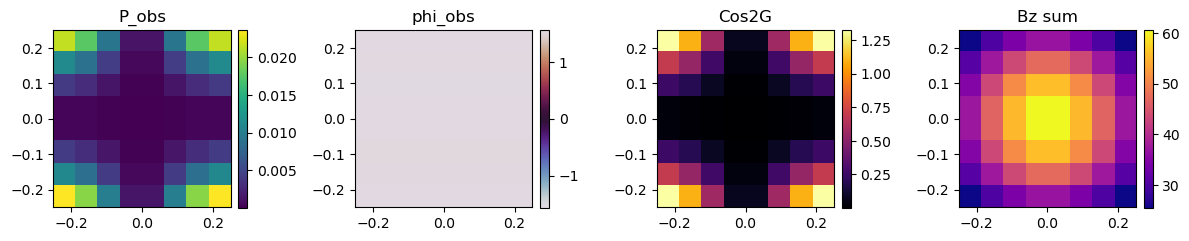

In [458]:
fig, axs = plt.subplots(1,4,figsize=(12,4))
im0 = axs[0].imshow(P_obs, origin='lower', extent=(r.min(), r.max(), r.min(), r.max()), cmap='viridis')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title('P_obs')

im1 = axs[1].imshow(phi_obs, origin='lower', extent=(r.min(), r.max(), r.min(), r.max()), cmap='twilight')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title('phi_obs')

im2 = axs[2].imshow(cos2g.sum(axis=iaxis), origin='lower', extent=(r.min(), r.max(), r.min(), r.max()), cmap='inferno')
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].set_title('Cos2G')

im3 = axs[3].imshow(Bz.sum(axis=iaxis), origin='lower', extent=(r.min(), r.max(), r.min(), r.max()), cmap='plasma')
plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
axs[3].set_title('Bz sum')

plt.tight_layout()

## Plotting vectors below, still not working well

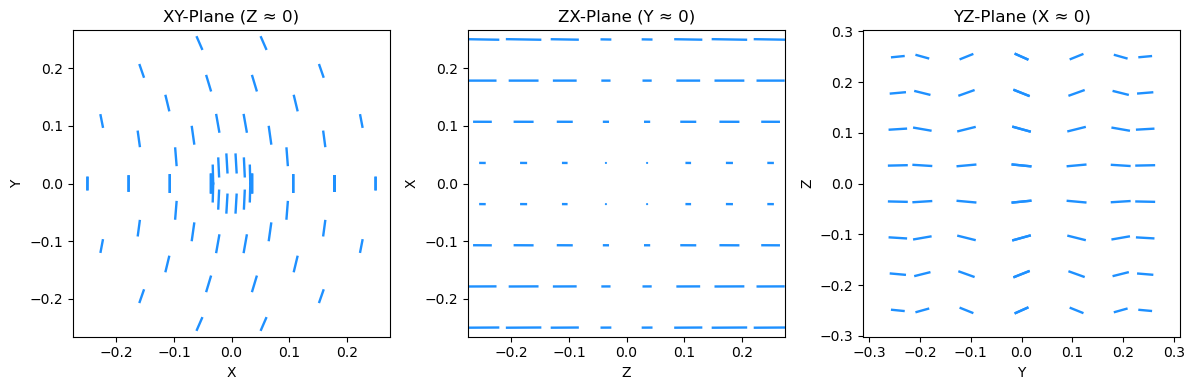

In [442]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].set_title('XY-Plane (Z ≈ 0)')
axs[0].quiver(X[:, :, 0], Y[:, :, 0], Bx[:, :, 0], By[:, :, 0],
            headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='dodgerblue')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].axis('equal')

axs[1].set_title('ZX-Plane (Y ≈ 0)')
axs[1].quiver(Z[0,:,:], X[0,:,:], Bz[0,:,:], Bx[0,:,:],
        headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='dodgerblue')
axs[1].set_xlabel('Z')
axs[1].set_ylabel('X')
axs[1].axis('equal')

axs[2].set_title('YZ-Plane (X ≈ 0)')
axs[2].quiver(Y[:,0,:], Z[:,0,:], By[:,0,:], Bz[:,0,:],
        headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='dodgerblue')
axs[2].set_xlabel('Y')
axs[2].set_ylabel('Z')
axs[2].axis('equal')

plt.tight_layout()
plt.show()

In [347]:
# # plot stokes map
# bi_stokes = np.sin(phi_obs)*P_obs
# bj_stokes = np.cos(phi_obs)*P_obs

# plt.figure(figsize=(5,5))
# if iaxis == 0:
#     plt.title('XY-Plane (Z ≈ 0)')
#     plt.quiver(i_pos[:,:,0], j_pos[:,:,0], bi_stokes, bj_stokes,
#                 headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
#     plt.xlabel('X')
#     plt.ylabel('Y')
# elif iaxis == 1:
#     plt.title('ZX-Plane (Y ≈ 0)')
#     plt.quiver(i_pos[0,:,:], j_pos[0,:,:], bi_stokes, bj_stokes,
#                 headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
#     plt.xlabel('Z')
#     plt.ylabel('X') 
# elif iaxis == 2:
#     plt.title('YZ-Plane (X ≈ 0)')
#     plt.quiver(i_pos[:,:,0], j_pos[:,:,0], bi_stokes, bj_stokes,
#                 headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
#     plt.xlabel('Y')
#     plt.ylabel('Z') 
# plt.tight_layout()
# plt.axis('equal')
# plt.show()

In [ ]:
# if iaxis == 0:
# #     fig = plt.figure(figsize=(5,5))
# #     ax = fig.add_subplot()
# #     ax.set_title('YZ-Plane (X ≈ 0)')    
# #     x = np.sin(phi_obs)*P_obs
# #     y = np.cos(phi_obs)*P_obs
# #     ax.quiver(Y[:,0,:], Z[:,0,:], x, y, angles = 'xy', scale=20, scale_units='xy',headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
# #     ax.set_xlabel('Y')
# #     ax.set_ylabel('Z')
# #     plt.show()

# # elif iaxis == 1:
# #     fig = plt.figure(figsize=(5,5))
# #     ax = fig.add_subplot()
# #     ax.set_title('ZX-Plane (Y ≈ 0)')
# #     x = np.sin(phi_obs)*P_obs
# #     y = np.cos(phi_obs)*P_obs
# #     ax.quiver(Z[0,:,:], X[0,:,:], x, y, angles = 'xy', scale=50, scale_units='xy',headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
# #     ax.set_xlabel('Z')
# #     ax.set_ylabel('X')
# #     plt.show()

# if iaxis == 2:
#     fig = plt.figure(figsize=(5,5))
#     ax = fig.add_subplot()
#     ax.set_title('Depolarized Stokes U and Q')
#     x = np.sin(phi_obs)*P_obs
#     y = np.cos(phi_obs)*P_obs
#     ax.quiver(X[:, :, 0], Y[:, :, 0], x, y, scale_units='xy', scale = 2, headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     plt.show()

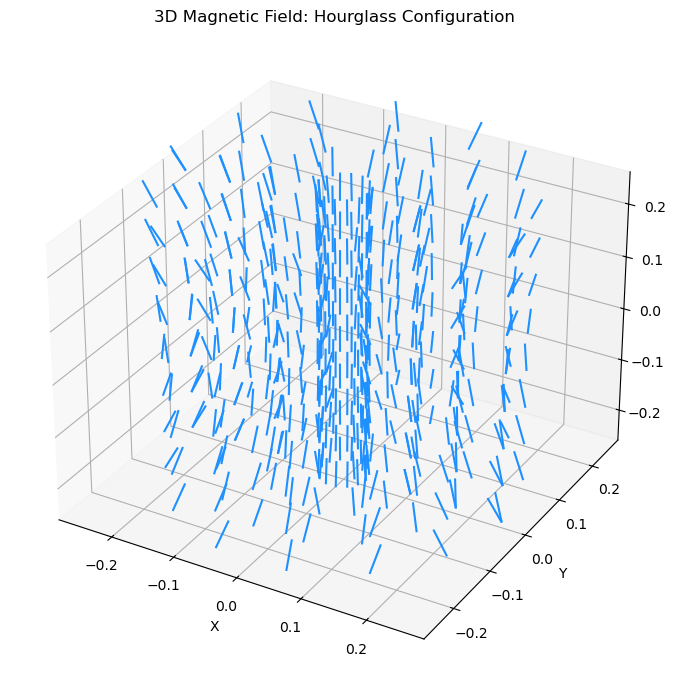

In [385]:
# # === PLOTTING ===
# bi_stokes = np.sin(phi_obs)*P_obs
# bj_stokes = np.cos(phi_obs)*P_obs

# # slice correctly depending on axis chosen.
# if axis == 0:
#     UQMAP = [u[:,:,0], q[:,:,0], cos2g[:,:,0]]
# elif axis == 1:
#     UQMAP = [u[0,:,:], q[0,:,:], cos2g[0,:,:]]
# elif axis == 2:
#     UQMAP = [u[:,0,:], q[:,0,:], cos2g[:,0,:]]


# plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, bx, by, bz, length=0.05, normalize=True,linewidth=1.5, arrow_length_ratio=0, color='dodgerblue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Magnetic Field: Hourglass Configuration')
plt.tight_layout()
plt.show()

